This notebook allows for the visualization of training metrics, reconstruction quality and latent space embeddings for some pre-trained models.

In [39]:
import os
import yaml
from models.lit_model import LitModel
from torchsummary import summary

version = 2 # 1 to 6
path = f"lightning_logs/version_{version}/"

with open(os.path.join(path, "hparams.yaml")) as f:
    hparams = yaml.safe_load(f)

ckpt = [f for f in os.listdir(path) if f.endswith(".ckpt")][1]

litmodel = LitModel.load_from_checkpoint(
    checkpoint_path=os.path.join(path, ckpt), config=hparams["config"]
)
model = litmodel.model
model.eval()

print(f"{hparams["model_type"]} model")

# model summary
summary(model, (3, 80, 80))


/u/sasit/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:829: UserWarning:

Can't initialize NVML



vanilla model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 40, 40]           2,368
       BatchNorm2d-2           [-1, 16, 40, 40]              32
              GELU-3           [-1, 16, 40, 40]               0
            Conv2d-4           [-1, 32, 20, 20]          12,832
       BatchNorm2d-5           [-1, 32, 20, 20]              64
              GELU-6           [-1, 32, 20, 20]               0
            Conv2d-7           [-1, 64, 10, 10]          51,264
       BatchNorm2d-8           [-1, 64, 10, 10]             128
              GELU-9           [-1, 64, 10, 10]               0
           Conv2d-10            [-1, 128, 5, 5]          73,856
      BatchNorm2d-11            [-1, 128, 5, 5]             256
             GELU-12            [-1, 128, 5, 5]               0
           Conv2d-13            [-1, 256, 3, 3]         295,168
      BatchNorm2d-14     

/u/sasit/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


torch.Size([15, 3, 80, 80])


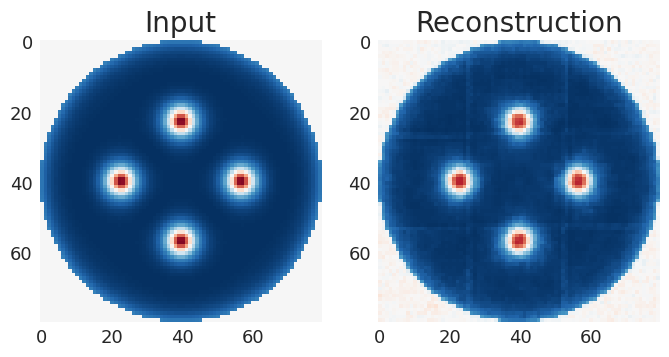

In [ ]:

from plot import reconstruction
import torch

example_sims = torch.load("data/example_sims.pt")

reconstruction(model, example_sims, i=12) # index between 0 and 14, picked randomly if not specified


In [ ]:
from plot import training_log

training_log(version=[version])

In [38]:
%matplotlib widget
from sklearn.cluster import DBSCAN
import os
import torch
from plot import scatter_interactive

latent_space = torch.load(
    os.path.join(f"lightning_logs/version_{version}/latent_space_per_epoch/199.pth")
)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(latent_space)

scatter_interactive(clusters)

FigureWidget({
    'data': [{'customdata': [data/field_images/0.png, data/field_images/2.png,
                             data/field_images/3.png, ...,
                             data/field_images/3006.png,
                             data/field_images/3007.png,
                             data/field_images/3009.png],
              'hovertemplate': 'H: %{x}<br>E: %{y}<extra></extra>',
              'marker': {'color': '#2E91E5', 'size': 11},
              'mode': 'markers',
              'name': 'Class 0',
              'type': 'scatter',
              'uid': '5f2379ab-5f20-4a74-9fc0-0bb61905a40d',
              'x': [0.5238139349280231, 0.5238139349280231, 0.5238139349280231,
                    ..., 0.5785806608969681, 0.5785806608969681,
                    0.5785806608969681],
              'y': [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]},
             {'customdata': [data/field_images/1.png, data/field_images/15.png,
                             data/field_images/26.png, ...,
      

Clustering results: DBSCAN with eps=0.5, min_samples=5 gives 10 clusters with some noise points (-1).

In [5]:
from cluster_acc import purity, adj_rand_index

print("Purity: ", purity(clusters))
print("Adjusted Rand Index: ", adj_rand_index(clusters))

Purity:  0.9953488372093023
Adjusted Rand Index:  0.9985908959894364


/u/sasit/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:829: UserWarning:

Can't initialize NVML



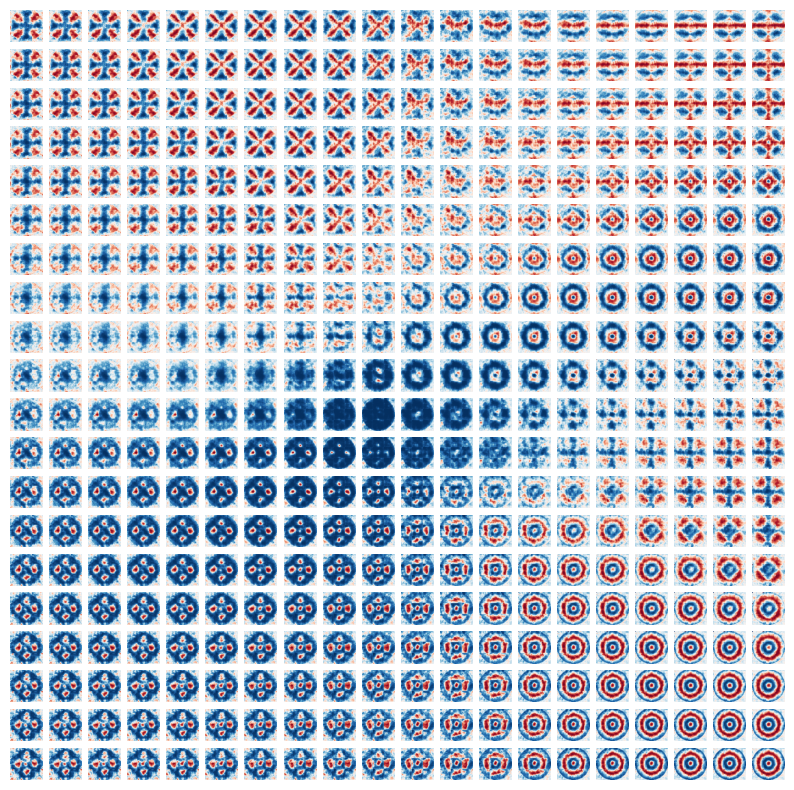

In [ ]:
import matplotlib.pyplot as plt
from models.lit_model import DataModule
import torch
import numpy as np

data_module = DataModule(batch_size=64, num_workers=2)
data_module.setup()

latent_space = model.encoder(data_module.data)

n_points = 20
grid = np.array(
    np.meshgrid(np.linspace(-20, 20, n_points), np.linspace(-20, 20, n_points))
).T.reshape(-1, 2)

# convert to tensor
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# decode the grid points
with torch.no_grad():
    decoded_points = litmodel.model.decoder(grid_tensor).numpy()

fig, ax = plt.subplots(n_points, n_points, figsize=(10, 10))
for i in range(n_points):
    for j in range(n_points):
        idx = i * n_points + j
        point = decoded_points[idx].reshape(
            decoded_points.shape[2], decoded_points.shape[3], decoded_points.shape[1]
        )
        ax[i, j].imshow(point[..., 2], vmin=-1, vmax=1, cmap="RdBu")
        ax[i, j].axis("off")
plt.show()

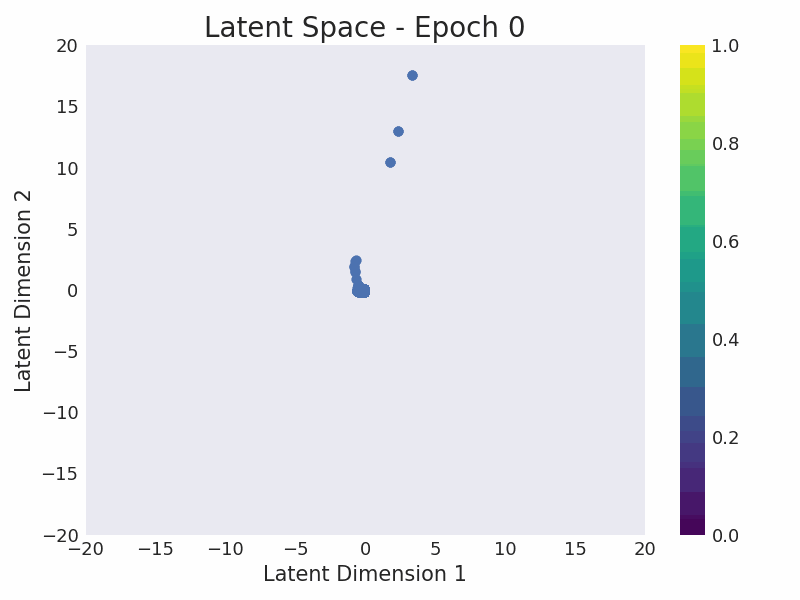

In [40]:
from IPython.display import Image
Image(filename="latent_space_vanilla.gif")

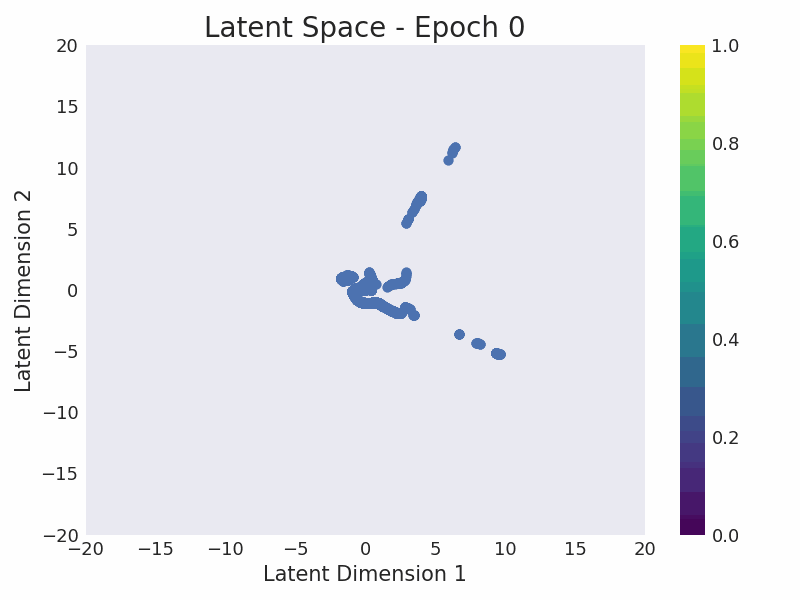

In [37]:
from IPython.display import Image
Image(filename="latent_space_variational.gif")